In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
import csv
import scipy.stats as stats
from tensorboard.plugins.hparams import api as hp
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [3]:
def split_sequence(sequence, n_steps, h_steps = 0):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps 
        # check if we are beyond the sequence
        if end_ix + h_steps > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + h_steps]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def train_test_split_ts_2d_raw(X, h):
    return(X[:-h],X[-h:])


def train_test_split_ts(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

def train_test_split_one(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index],X[split_index:],y[:split_index],y[split_index:])

def train_test_split_ts_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:,:],X[split_index:,:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d(X, y, test_size=0.2):
    r = X.shape[0]
    split_index = int((1-test_size)*r)
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

def train_test_split_ts_2d_index(X, y, split_index):
    r = X.shape[0]
    return(X[:split_index,:],X[split_index:,:],y[:split_index],y[split_index:])

In [4]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size)]
        data_X.append(a)
        data_Y.append(dataset[i + window_size])
    return(np.array(data_X), np.array(data_Y))

In [5]:
def forecast(first_item, model, h, n_step):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        y = model.predict(np.reshape(x,(1,len(x))))
        result.append(y)
        x = np.append(x[1:],np.array(y))
    return(np.array(result))   

In [6]:
def forecast_sst(first_item,sst_last, model, h, n_step):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        x = np.append(x,sst_last[i])
        y = model.predict(np.reshape(x,(1,len(x))))
        result.append(y)
        x = np.append(x[1:-1],np.array(y))
    return(np.array(result))

In [9]:
def forecast_sst_n(first_item,sst_last, model, h, n_step, n_sst):
    x = first_item
    result = []
    #x = np.reshape(x,(1,20))
    for i in range(h):
        x = np.append(x,sst_last[i])
        y = model.predict(np.reshape(x,(1,len(x))))
        result.append(y)
        x = np.append(x[1:-n_sst],np.array(y))
    return(np.array(result))

In [10]:
def build_model(n_steps, n_units, learning_rate, optimizer_name):
    model = keras.Sequential()
    if len(n_units) == 1:
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
    else:  
        model.add(layers.Dense(n_units[0], activation=tf.nn.relu, input_dim=n_steps))
        for i in range(1,len(n_units)):
            model.add(layers.Dense(n_units[i], activation=tf.nn.relu))
    
    model.add(layers.Dense(1))
    
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate)

    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [11]:
def cv_hparam_tunning(x, n_steps, num_units, optimizer, learning_rate,
                      training_window=15, forecast_window=1, freq=12,epochs=1):

    fuzzify(x)
    L = len(x)
    errors = []
    
    for i in range(0, L - (training_window+forecast_window)*freq, freq):   

        raw_seq = x[i:i+(training_window + forecast_window)*freq]

        X, y_test = train_test_split_ts_2d_raw(raw_seq, forecast_window*freq) 
        X_train, y_train = split_sequence(X, n_steps)

        #estimator = KerasRegressor(build_fn=baseline_ model(n_steps), epochs=100, batch_size=5, verbose=0)
        model = build_model(n_steps, num_units, learning_rate, optimizer)


        #EPOCHS = 100
        model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)

        y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, freq, n_steps)
        y_hat = np.reshape(y_hat,len(y_test))
        if np.any(np.isnan(y_hat)):
            errors.append(np.nan)
        else:
            errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

        #errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))
        
    return(np.nanmean(errors))

In [12]:
def uni_deseasonalize(ts,freq=12):
    ts = np.array(ts)
    avgs = np.zeros(freq)
    stds = np.zeros(freq)
    N = len(ts)
    #averages = np.zeros((freq,n))
    temp = ts
    result = np.zeros((N))
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        avgs[j] = temp[Idx].mean()
        stds[j] = temp[Idx].std()
        result[Idx] = (temp[Idx] - temp[Idx].mean())#/temp[Idx].std()
    return(result, avgs) 

In [44]:
data = pd.read_csv("droughtSST12.csv")

In [45]:
data

Unnamed: 0  drought       sst2     sst41     sst72  drought1  drought12
0            13       32  -7.848510  0.989585 -3.449286      30.0       54.0
1            14       30 -15.507652 -0.081156 -5.879403      32.0       38.0
2            15       30 -25.191986  1.641278 -2.686439      30.0       42.0
3            16       10 -23.034614 -1.733567 -4.684590      30.0       43.0
4            17       16  -9.125324  3.342970 -1.237073      10.0       53.0
..          ...      ...        ...       ...       ...       ...        ...
450         463       26  34.922166 -1.067977 -2.875524      11.0        0.0
451         464       39  37.891602  1.432836 -0.979347      26.0       11.0
452         465       61  44.742732 -3.105194  1.964686      39.0       10.0
453         466       87  48.279216 -0.223769 -0.028918      61.0       12.0
454         467       82  44.709146  1.321748 -3.348815      87.0       11.0

[455 rows x 7 columns]

In [47]:
X = data.iloc[:,[2,5,6]].values
y = data.drought.values

In [48]:
#x_train, x_test,y_train, y_test =  train_test_split_one(X, y, test_size=0.2)
x_train, x_test,y_train, y_test = train_test_split_ts(X, y, test_size=0.2)

In [49]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
layers.Dense(1)
])


model.compile(optimizer="RMSprop",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

model.fit(x_train, y_train, epochs=100, verbose=False) 

In [50]:
y_hat = model.predict(x_test)
y_hat = np.reshape(y_hat,len(y_test))

In [31]:
#one 
math.sqrt(((y_hat - y_test)**2).mean())

14.93119225740786

In [43]:
#two
math.sqrt(((y_hat - y_test)**2).mean())

15.32293315012722

In [51]:
#three
math.sqrt(((y_hat - y_test)**2).mean())

15.109698331878107

In [69]:
data = pd.read_csv("droughtSST12.csv")
data = data.iloc[:,1:]

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 12
h = f*m
N = data.shape[0] - (n + m)*f
result = np.zeros(N)
index = 0

In [70]:
raw_seq = data.iloc[index:index+(n+m)*f,:]
X,y = split_sequence(raw_seq.drought.values, n_steps)
sst = raw_seq.iloc[n_steps:,1:].values

In [71]:
X = np.hstack((X,sst))
x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [72]:
n_sst = sst.shape[1]

In [73]:
model = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
layers.Dropout(0.1),
layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
layers.Dense(1)
])


model.compile(optimizer="RMSprop",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

model.fit(x_train, y_train, epochs=100, verbose=False) 

sst_last = sst[-f*m:,:]

In [75]:
y_hat = forecast_sst_n(np.append(x_train[-1][1:-n_sst],np.array(y_train[-1])),sst_last, model, h, n_steps, n_sst)
y_hat = np.reshape(y_hat,len(y_test))

14.93119225740786

In [26]:
data = pd.read_csv("droughtSSTAvg.csv")
data = data.iloc[:,1:]

n = 30
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
freq = 12
n_steps = 12
h = freq*m
N = data.shape[0] - (n + m)*freq
result_list = []
result = np.zeros(N)
result_witoutSST = np.zeros(N)
for index in range(N):

    raw_seq = data.iloc[index:index+(n+m)*freq,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps)

    #No SST
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)

    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
    y_hat = np.reshape(y_hat,len(y_test))

    
    result_witoutSST[index] = math.sqrt(mean_squared_error(y_hat, y_test))
    
    #result_witoutSST[index] = math.sqrt((y_hat[-1] - y_test[-1])**2)

    #SST
    sst = raw_seq.sst.values[n_steps:]

    X = np.hstack((X,sst.reshape(-1,1)))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)

    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    sst_last = sst[-12:]
    y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, model, h, n_steps)
    y_hat = np.reshape(y_hat,len(y_test))
    
    result[index] = math.sqrt(mean_squared_error(y_hat, y_test))

    #result[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 

fields=[result.mean(), result_witoutSST.mean()]
print(fields)
with open('ET_resultTempNN.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

[28.392015135972606, 29.7108330203212]


In [17]:
def studentT_test_one(var, h_mean = 0):
    n = len(var)
    mean = np.mean(var)
    std = np.std(var)

    t_test = (mean - h_mean) / (std/math.sqrt(n)) 
    p_value = 1 - stats.t.cdf(t_test, n - 1)
    
    return(t_test, p_value)

In [18]:
studentT_test_one(result_witoutSST - result)

(0.5789981959898775, 0.28207922078342296)

In [21]:
stats.ttest_rel(result_witoutSST, result)

Ttest_relResult(statistic=0.5755414594478382, pvalue=0.566482305301515)

# 12 Months

In [14]:
data = pd.read_csv("droughtSST12.csv")
data = data.iloc[:,1:]

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 12
h = f*m
N = data.shape[0] - (n + m)*f
result = np.zeros(N)


for index in range(N):

    raw_seq = data.iloc[index:index+(n+m)*f,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps)
    sst = raw_seq.iloc[n_steps:,1:].values
    
    X = np.hstack((X,sst))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)
    
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="adam",
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    sst_last = sst[-f * m:,:]
    y_hat = forecast_sst_n(np.append(x_train[-1][1:-n_sst],np.array(y_train[-1])),sst_last, model, h, n_steps, n_sst)
    y_hat = np.reshape(y_hat,len(y_test))
    
    result[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 

NameError: name 'n_sst' is not defined

In [79]:
result.mean()

35.423366891110646

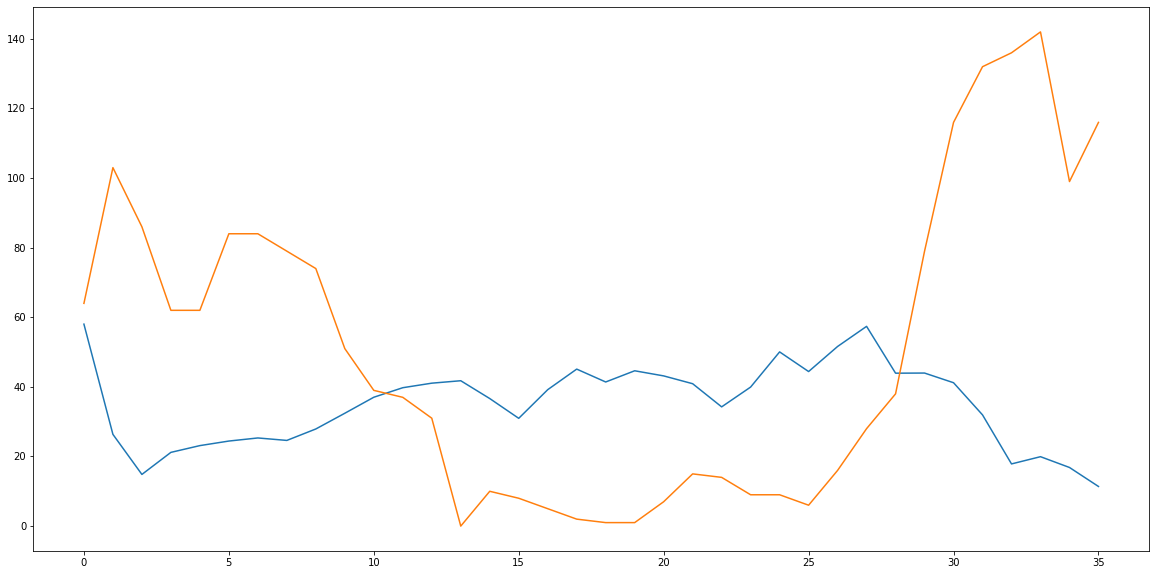

In [226]:
plt.plot(range(len(pred)), pred.reshape((1,-1))[0], y_test)

In [233]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 12
h_steps = 11
N = data.shape[0] - (n + m)*f
result = []
h = m * f
for index in range(N):

    raw_seq = data.iloc[index:index+(n+m)*f,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps, h_steps)
    sst = raw_seq.sst.values[n_steps:-h_steps]

    X = np.hstack((X,sst.reshape(-1,1)))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)

    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="RMSprop",
                loss='mean_squared_error',
                 metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    y_hat = model.predict(x_test)
    
    y_hat = y_hat.reshape((1,-1))[0]

    result.append(math.sqrt(((y_hat - y_test)**2).mean()))

In [237]:
np.mean(result)

37.703552395700115

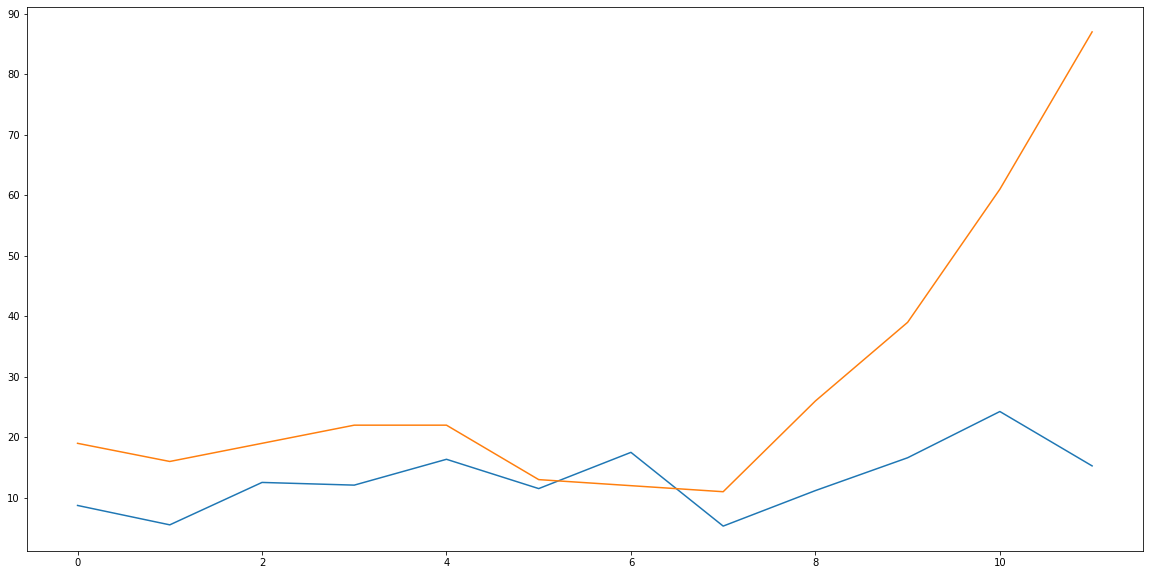

In [239]:
plt.plot(range(len(y_hat)), y_hat.reshape((1,-1))[0], y_test)

# 12 Mixed

In [130]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 12
h_steps = 11
N = data.shape[0] - (n + m)*f
result = np.zeros(N)
h = m * f
y_hat_list = []
y_test_list = []
for index in range(N):

    raw_seq = data.iloc[index:index+(n+m)*f,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps, h_steps)
    sst = raw_seq.sst.values[n_steps:-h_steps]
    
    X = np.hstack((X,sst.reshape(-1,1)))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)
    
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="RMSprop",
                loss='mean_squared_error',
                 metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    sst_last = sst[-12:]
    y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, model, h, n_steps)
    y_hat = np.reshape(y_hat,len(y_test))
    
    result[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 
    y_hat_list.append(y_hat[-1])
    y_test_list.append(y_test[-1])

KeyboardInterrupt: 

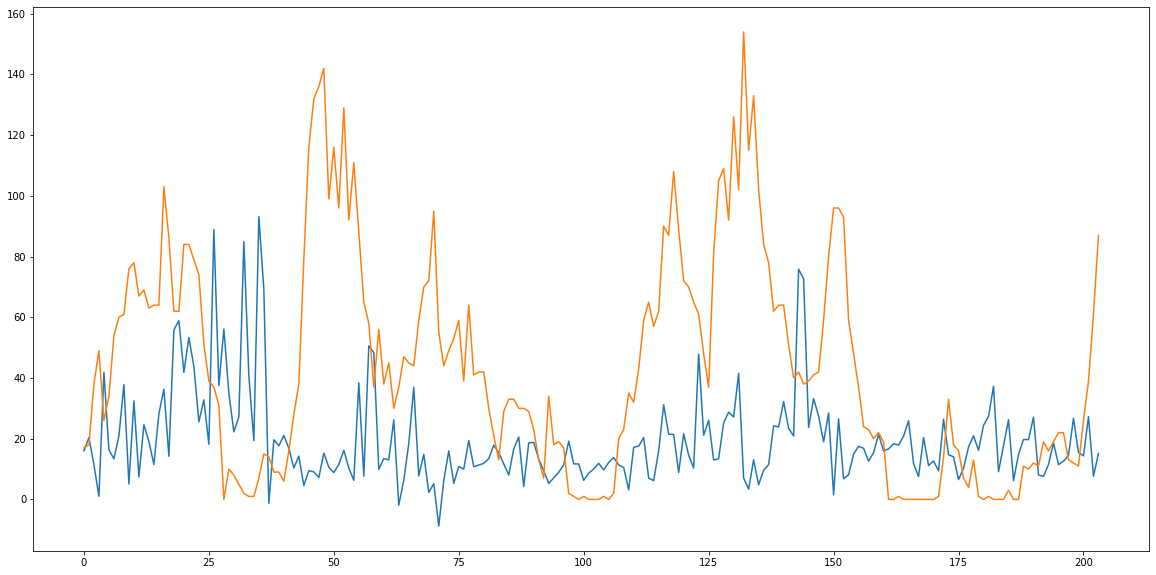

In [92]:
plt.plot(range(len(y_hat_list)), y_hat_list, y_test_list)

In [65]:
result.mean()

35.28321073978555

In [32]:
result.mean()

36.39197116578911

In [40]:
result.sum()/np.count_nonzero(result)

31.868235599703905

In [18]:
result.mean()

36.83620018365921

In [66]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 12
h = f*m

N = data.shape[0] - (n + m)*f
result_witoutSST = np.zeros(N)

for index in range(N):

    raw_seq = data.iloc[index:index+(n+m)*f,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps)
    #sst = raw_seq.sst.values[n_steps:]
    
    #X = np.hstack((X,sst.reshape(-1,1)))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)
    
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
    ])

    model.compile(optimizer="RMSprop",
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    #sst_last = sst[-12:]
    y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
    y_hat = np.reshape(y_hat,len(y_test))
    
    result_witoutSST[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 

KeyboardInterrupt: 

In [64]:
result_witoutSST.mean()

6.862262426638136

In [42]:
result.sum()/np.count_nonzero(result_witoutSST)

31.868235599703905

# ONI

In [51]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

In [52]:
oni = pd.read_csv("ONI.csv")

In [53]:
new_oni = oni.iloc[324:780,5].values

In [54]:
data["sst"] = new_oni

In [55]:
data.drought.mean()

49.23684210526316

In [56]:
data.drought.std()

38.15533379252461

In [40]:
data = (data - data.mean())/data.std()

In [60]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

oni = pd.read_csv("ONI.csv")
new_oni = oni.iloc[324:780,5].values
data["sst"] = new_oni

#data = (data - data.mean())/data.std()

n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
h = m*f
n_steps = 12
N = data.shape[0] - (n + m)*f
result = np.zeros(N)

for index in range(0,N):

    raw_seq = data.iloc[index:index+(n+m)*f,:]
    X,y = split_sequence(raw_seq.drought.values, n_steps)
    sst = raw_seq.sst.values[n_steps:]
    
    X = np.hstack((X,sst.reshape(-1,1)))
    x_train, x_test = train_test_split_ts_2d_raw(X, h)
    y_train, y_test = train_test_split_ts_2d_raw(y, h)
    
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
    ])


    model.compile(optimizer="RMSprop",
                loss='mean_squared_error',
                 metrics=['RootMeanSquaredError'])
    
    model.fit(x_train, y_train, epochs=100, verbose=False) 

    sst_last = sst[-12:]
    y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, model, h, n_steps)
    y_hat = np.reshape(y_hat,len(y_test))
    
    result[index] = math.sqrt((y_hat[-1] - y_test[-1])**2)

In [61]:
result.mean()

35.70480540453219

In [59]:
result

array([ 77.02858431, 120.87812246,  75.30829842,  80.68835321,
        91.53693443,  91.86390427,  68.40573872,  77.18698068,
        72.25358106,  60.57164216,  72.42647765,  75.46522502,
        97.06945693,  62.12646708,  95.42049403,  80.65562996,
        69.5810966 ,  99.20941965,  88.51848871, 106.66449462,
        85.77686819,  86.78408656,  87.61294522,  70.42503707,
       114.21164774, 121.41616766, 125.29029873, 109.5588329 ,
       144.99661456, 138.83172723, 152.18650668, 151.30182321,
       150.8728909 , 109.10972141, 146.35571964, 123.32299629,
       113.42790951, 127.65752112, 127.67560556,  77.72776754,
        83.78385887,  87.30505914, 103.79086648,  75.18231804,
        65.01873785, 144.90845093, 146.4806049 , 121.54780423,
       123.65763054,  79.11288734,  94.86861576,  73.59215722,
       109.98097936,  66.04922641, 127.97386584,  74.88092507,
        82.81630136,  65.23789254,  84.99712765,  72.08547141,
        81.0614656 ,  62.31832531,  74.56023803,  77.72

In [81]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

In [82]:
data

drought        sst
0         30  -3.538382
1         32  -7.848510
2         30 -15.507652
3         30 -25.191986
4         10 -23.034614
..       ...        ...
451       26  34.922166
452       39  37.891602
453       61  44.742732
454       87  48.279216
455       82  44.709146

[456 rows x 2 columns]

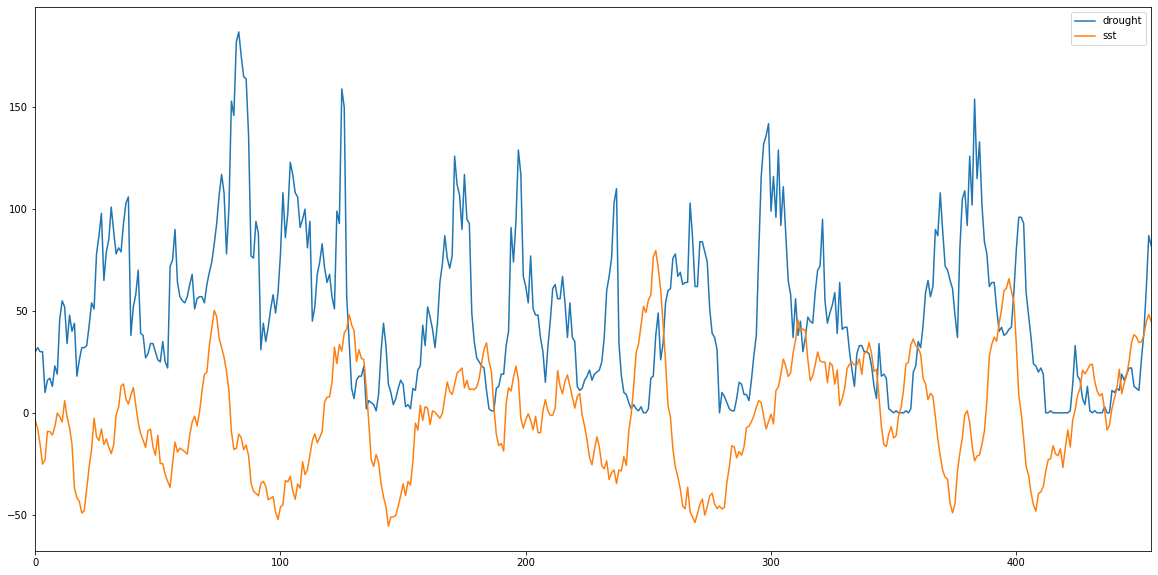

In [85]:
data.plot()

In [87]:
data.drought.mean()

49.23684210526316

In [86]:
data.drought.std()

38.15533379252461

# Tunning

In [11]:
NUM_UNITS1 = [8]
NUM_UNITS2 = [8]
DROPOUTS = [0.1]
OPTIMIZERS = ['RMSprop']

In [12]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

n = 30
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
freq = 12
n_steps = 12
h = freq*m
N = data.shape[0] - (n + m)*freq
result_list = []
for num_units1 in NUM_UNITS1:
    for num_units2 in NUM_UNITS2:
        for droupout in DROPOUTS:
            for optimizer in OPTIMIZERS:
                result = np.zeros(N)
                result_witoutSST = np.zeros(N)
                for index in range(N):

                    
                    raw_seq = data.iloc[index:index+(n+m)*freq,:]
                    X,y = split_sequence(raw_seq.drought.values, n_steps)
                    
                    #No SST
                    x_train, x_test = train_test_split_ts_2d_raw(X, h)
                    y_train, y_test = train_test_split_ts_2d_raw(y, h)
    
                    model = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
                    layers.Dense(num_units1, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
                    layers.Dropout(droupout),
                    layers.Dense(num_units2, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
                    layers.Dense(1)
                    ])

                    model.compile(optimizer=optimizer,
                        loss='mean_squared_error',
                        metrics=['RootMeanSquaredError'])
    
                    model.fit(x_train, y_train, epochs=100, verbose=False) 
 
                    y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
                    y_hat = np.reshape(y_hat,len(y_test))
    
                    result_witoutSST[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 
                                                   
                    #SST
                    sst = raw_seq.sst.values[n_steps:]

                    X = np.hstack((X,sst.reshape(-1,1)))
                    x_train, x_test = train_test_split_ts_2d_raw(X, h)
                    y_train, y_test = train_test_split_ts_2d_raw(y, h)

                    model = tf.keras.Sequential([
                    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
                    layers.Dense(num_units1, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
                    layers.Dropout(droupout),
                    layers.Dense(num_units2, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
                    layers.Dense(1)
                    ])

                    model.compile(optimizer=optimizer,
                                loss='mean_squared_error',
                                metrics=['RootMeanSquaredError'])

                    model.fit(x_train, y_train, epochs=100, verbose=False) 

                    sst_last = sst[-12:]
                    y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, model, h, n_steps)
                    y_hat = np.reshape(y_hat,len(y_test))

                    result[index] = math.sqrt((y_hat[-1] - y_test[-1])**2) 
                
                fields=[num_units1, num_units2, droupout, optimizer,result.mean(), result_witoutSST.mean()]
                print(fields)
                with open('ET_resultTemp.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow(fields)
   
        

[8, 8, 0.1, 'RMSprop', 30.904726652162417, 30.69881916613806]


In [17]:
result.shape

(84,)

In [15]:
studentT_test_one(result_witoutSST - result)

(0.8321223701973063, 0.2031588457958744)

In [14]:
def studentT_test_one(var, h_mean = 0):
    n = len(var)
    mean = np.mean(var)
    std = np.std(var)

    t_test = (mean - h_mean) / (std/math.sqrt(n)) 
    p_value = 1 - stats.t.cdf(t_test, n - 1)
    
    return(t_test, p_value)

In [ ]:
[8, 8, 0.1, 'RMSprop', 36.22277104182571, 36.70123159943842]

In [63]:
studentT_test_one(result_witoutSST - result)

(0.95574278106171, 0.17098883078613425)

In [61]:
studentT_test_one(result_witoutSST - result)

(0.48308786372333146, 0.3147769735447786)

In [57]:
studentT_test_one(result_witoutSST - result)

(0.42927716651614833, 0.3340883892473686)

In [80]:
studentT_test_one(result_witoutSST - result)

(1.6849546722177078, 0.04676699471780421)

p_value is 0.046

# hyperparameter tuning

In [11]:
data = pd.read_csv("droughtSST.csv")
data = data.iloc[:,1:]

In [18]:
n = 20
# Set forecasting window length (in years)
m = 1
# Set annual sampling rate
f = 12
n_steps = 10
index = 0
h = m*f

In [13]:
raw_seq = data.iloc[index:index+(n+m)*f,:]

In [14]:
X,y = split_sequence(raw_seq.drought.values, n_steps)

In [15]:
sst = raw_seq.sst.values[n_steps:]

In [16]:
X = np.hstack((X,sst.reshape(-1,1)))

In [19]:
x_train, x_test = train_test_split_ts_2d_raw(X, h)
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [20]:
!rm -rf ./logs/

%load_ext tensorboard

In [21]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([8,16,32])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([8,16,32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
12/12 [==============================] - 0s 5ms/sample - loss: 111.5802 - RootMeanSquaredError: 10.5625
mis_rmse 10.562544822692871
--- Starting trial: run-1
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
12/12 [==============================] - 0s 7ms/sample - loss: 182.2496 - RootMeanSquaredError: 13.4993
--- Starting trial: run-2
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 7ms/sample - loss: 661296381952.0000 - RootMeanSquaredError: 53.3397
--- Starting trial: run-3
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
12/12 [==============================] - 0s 5ms/sample - loss: 129.4499 - RootMeanSquaredError: 11.3768
--- Starting trial: run-4
{'num_units 1': 8

--- Starting trial: run-35
{'num_units 1': 8, 'num_units 2': 32, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 7ms/sample - loss: nan - RootMeanSquaredError: nan
--- Starting trial: run-36
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
12/12 [==============================] - 0s 20ms/sample - loss: 89.1731 - RootMeanSquaredError: 9.4419
--- Starting trial: run-37
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
12/12 [==============================] - 0s 5ms/sample - loss: 97.7612 - RootMeanSquaredError: 9.8861
--- Starting trial: run-38
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 5ms/sample - loss: inf - RootMeanSquaredError: 36797.2930
--- Starting trial: run-39
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.1, 'l2 regul

--- Starting trial: run-71
{'num_units 1': 16, 'num_units 2': 32, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 5ms/sample - loss: 23286118992108499463978352640.0000 - RootMeanSquaredError: 152597889548288.0000
--- Starting trial: run-72
{'num_units 1': 32, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
12/12 [==============================] - 0s 6ms/sample - loss: 106.9525 - RootMeanSquaredError: 10.3404
--- Starting trial: run-73
{'num_units 1': 32, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
12/12 [==============================] - 0s 5ms/sample - loss: 153.7696 - RootMeanSquaredError: 12.3993
--- Starting trial: run-74
{'num_units 1': 32, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 5ms/sample - loss: nan - RootMeanSquaredError: nan
--- Starting trial: run-75
{'num_units 1': 32

--- Starting trial: run-107
{'num_units 1': 32, 'num_units 2': 32, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
12/12 [==============================] - 0s 5ms/sample - loss: nan - RootMeanSquaredError: nan


In [22]:
%tensorboard --logdir logs/hparam_tuning

In [23]:
min_rmse

4.0423408

In [24]:
list(best_hparams.values())

[32, 8, 0.3, 0.01, 'RMSprop']

In [288]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(30, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

In [310]:
model.compile(optimizer="adam",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [311]:
model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 5ms/sample - loss: 184.8800 - RootMeanSquaredError: 13.5964


In [195]:
predictions = model.predict(x_test)

In [260]:
math.sqrt(mean_squared_error(y_test,predictions))

13.716265866362638

In [291]:
sst_last = sst[-12:]

In [312]:
y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])),model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [313]:
y_hat[-1]

16.612852

In [314]:
y_test[-1]

87

In [292]:
y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [293]:
y_hat[-1]

32.651592

In [294]:
y_test[-1]

87

In [208]:
math.sqrt(mean_squared_error(y_test,y_hat))

17.423708353983198

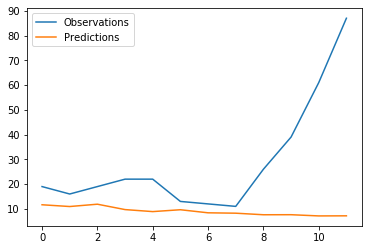

In [280]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [201]:
from sklearn.ensemble import RandomForestRegressor

In [202]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [203]:
regr.fit(x_train, y_train)

/home/mathsys2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [204]:
sst_last = sst[-12:]

y_hat = forecast_sst(np.append(x_train[-1][1:-1],np.array(y_train[-1])),sst_last, regr, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

math.sqrt(mean_squared_error(y_test,y_hat))

32.034015638323126

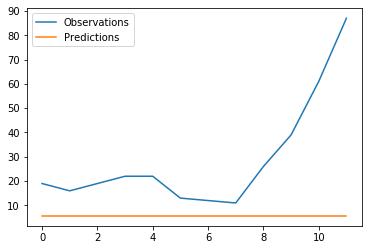

In [205]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [183]:
y_hat[11]

5.676576971757105

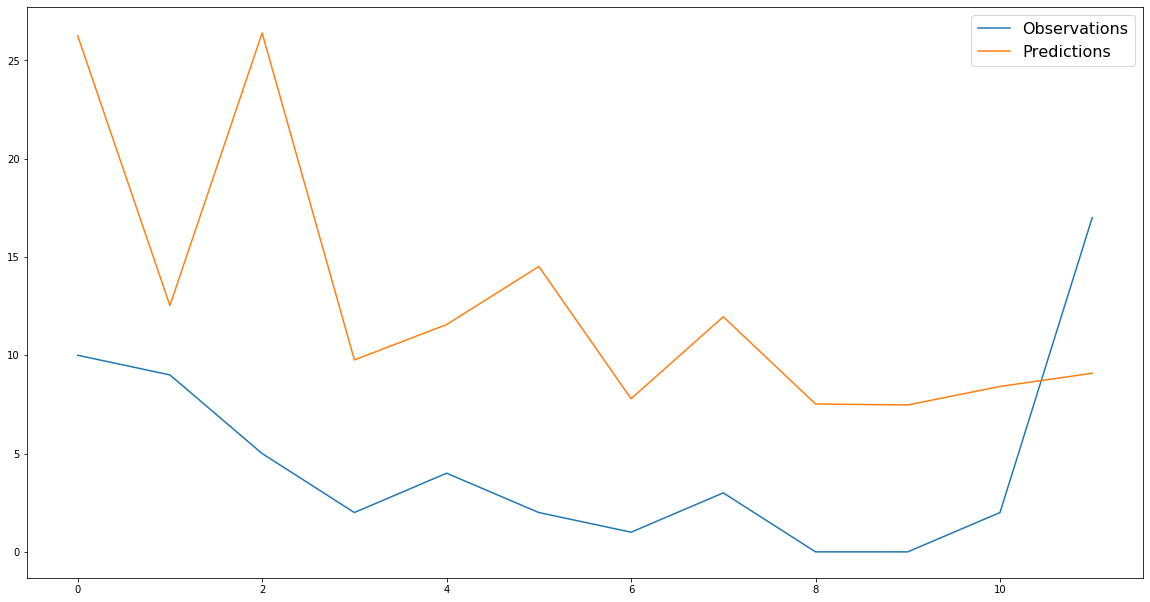

In [60]:
fig = plt.gcf()
fig.set_size_inches(20, 10.5)
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend(fontsize = 16)

(0, 20)

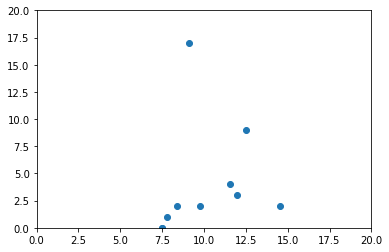

In [61]:
plt.scatter(predictions, y_test)
plt.xlim((0,20))
plt.ylim((0,20))

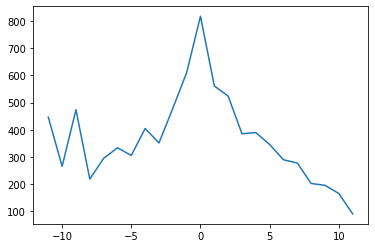

In [62]:
predictions = np.squeeze(predictions)
c = np.correlate(predictions,y_test, "full")

x_c = np.arange(-len(predictions)+1,len(predictions))

plt.plot(x_c,c)

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([0.23229196, 0.41442301, 0.19135831, 0.25789475, 0.29193529,
        0.26738799, 0.35393116, 0.30759402, 0.41864745, 0.53336809,
        0.71468323, 0.49085252, 0.4580624 , 0.33714145, 0.34098204,
        0.30256236, 0.25356974, 0.24298771, 0.17729656, 0.17131987,
        0.14511113]),
 <matplotlib.lines.Line2D at 0x7fcb14558550>)

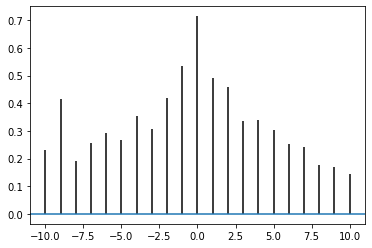

In [63]:
plt.xcorr(predictions,y_test)

In [424]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(4, activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, activation=tf.nn.relu),
    layers.Dense(1)
])

In [431]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
    layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dropout(0.1),
    layers.Dense(8, kernel_regularizer=tf.keras.regularizers.l2(0.01), activation=tf.nn.relu),
    layers.Dense(1)
])

In [432]:
model.compile(optimizer="RMSProp",
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [436]:
model.fit(x_train, y_train, epochs=100, verbose=False) 

_, rmse = model.evaluate(x_test, y_test)

48/48 [==============================] - 0s 65us/sample - loss: 18.1600 - RootMeanSquaredError: 4.2500


In [434]:
rmse

4.4760284

In [428]:
predictions = model.predict(x_test)

In [429]:
math.sqrt(mean_squared_error(y_test,predictions))

4.093961828487743

In [22]:
y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

math.sqrt(mean_squared_error(y_test,y_hat))

1.3121330443779999e+32

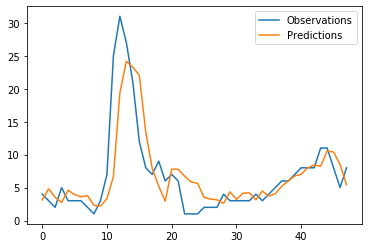

In [430]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), predictions, label="Predictions")
plt.legend()

In [367]:
y_test

array([ 4,  3,  2,  5,  3,  3,  3,  2,  1,  3,  7, 25, 31, 27, 21, 12,  8,
        7,  9,  6,  7,  6,  1,  1,  1,  2,  2,  2,  4,  3,  3,  3,  3,  4,
        3,  4,  5,  6,  6,  7,  8,  8,  8, 11, 11,  8,  5,  8])

In [368]:
predictions

array([[ 4.3304925],
       [ 4.1157084],
       [ 4.510546 ],
       [ 2.1828644],
       [ 4.7701654],
       [ 4.578716 ],
       [ 4.109888 ],
       [ 3.4815905],
       [ 3.6134114],
       [ 2.4285672],
       [ 2.6691763],
       [ 6.6833134],
       [20.75802  ],
       [29.71366  ],
       [26.457047 ],
       [21.636944 ],
       [15.348185 ],
       [ 8.876786 ],
       [ 4.997763 ],
       [ 6.7743354],
       [ 6.659576 ],
       [ 7.1900506],
       [ 5.728469 ],
       [ 4.671945 ],
       [ 4.2929974],
       [ 3.7907398],
       [ 3.4014685],
       [ 2.4700365],
       [ 2.674887 ],
       [ 2.8462791],
       [ 4.8797803],
       [ 4.3375816],
       [ 4.7033877],
       [ 5.591171 ],
       [ 5.25372  ],
       [ 4.1358533],
       [ 4.576705 ],
       [ 5.8609815],
       [ 6.9745603],
       [ 6.513139 ],
       [ 7.410751 ],
       [ 8.147883 ],
       [ 8.272674 ],
       [ 7.422599 ],
       [ 8.93429  ],
       [10.05007  ],
       [ 7.4488416],
       [ 5.80

In [115]:
df_oni = pd.DataFrame(x,
                  columns=["number"],
                  index=pd.date_range("19770101", periods=len(x), freq='MS'))

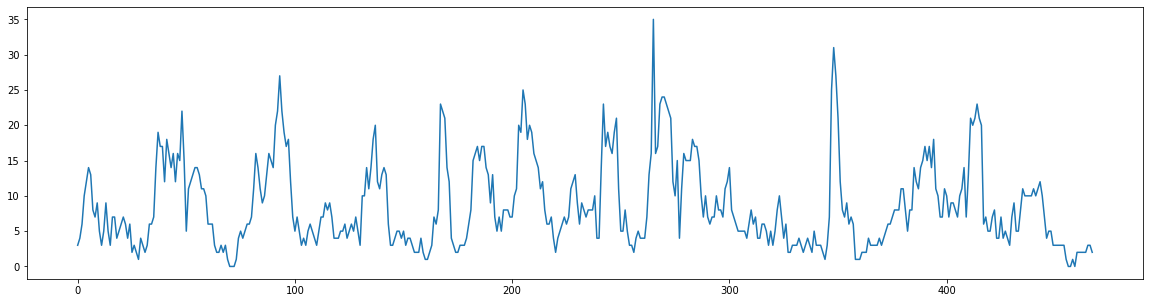

In [117]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x)

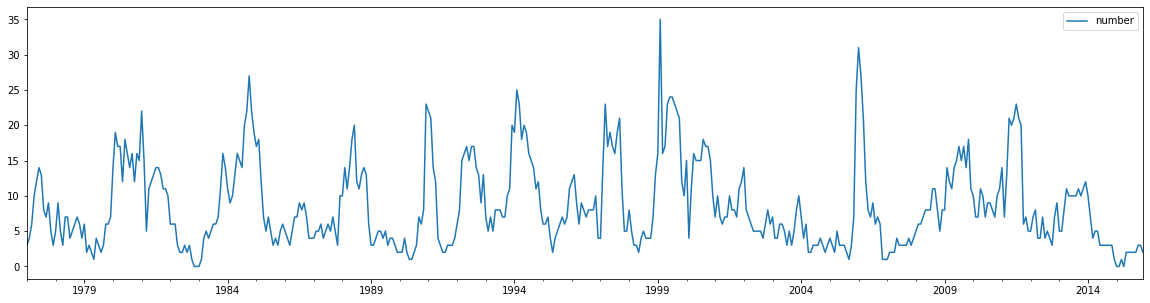

In [118]:
df_oni.plot()

In [114]:
df_oni

number
1970-01-01 00:00:00.000001980       3
1970-02-01 00:00:00.000001980       4
1970-03-01 00:00:00.000001980       6
1970-04-01 00:00:00.000001980      10
1970-05-01 00:00:00.000001980      12
...                               ...
2008-08-01 00:00:00.000001980       2
2008-09-01 00:00:00.000001980       2
2008-10-01 00:00:00.000001980       3
2008-11-01 00:00:00.000001980       3
2008-12-01 00:00:00.000001980       2

[468 rows x 1 columns]

In [38]:
raw_seq = x[index:index+(n+m)*f,:]

In [14]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)
x_train, y_train = split_sequence(X, n_steps)

In [15]:
x_test, y_test = split_sequence(y_test, n_steps)

In [65]:
X_train, y_train = split_sequence(X[:,0], n_steps)

In [66]:
oni_x = np.reshape(X[19:-1,1], (X_train.shape[0],1))
oni_y = np.reshape(X[19:-1,1], (X_train.shape[0],1))

In [67]:
X_train = np.hstack((oni_x, X_train))

In [ ]:
# define input sequence
raw_seq = x[index:index+(n+m)*f]
X, y_test = train_test_split_ts_2d_raw(raw_seq, h) 
#X, avgs = uni_deseasonalize(X)

X_train, y_train = split_sequence(X, n_steps)

In [86]:
raw_seq = x[index:index+(n+m)*f]

In [87]:
X, y = split_sequence(raw_seq, n_steps)

In [88]:
x_train, x_test = train_test_split_ts_2d_raw(X, h)

In [89]:
y_train, y_test = train_test_split_ts_2d_raw(y, h)

In [55]:
n_units = [16]
learning_rate = 0.001
optimizer = 'adam'
epochs = 100

In [59]:
n_units = [200,100,50,30,20,10]
learning_rate = 0.001
optimizer = 'adam'
epochs = 500

In [60]:
model = build_model(n_steps, n_units, learning_rate, optimizer)
model.fit(X_train, y_train, epochs=epochs, validation_split = 0.2, verbose=0)
y_hat = forecast(np.append(X_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [116]:
#avgs = np.tile(avgs, int(len(y_hat)/f))
#stds = np.tile(stds, int(len(y_hat)/f))

In [61]:
math.sqrt(mean_squared_error(y_test,y_hat))

8.306955666928031

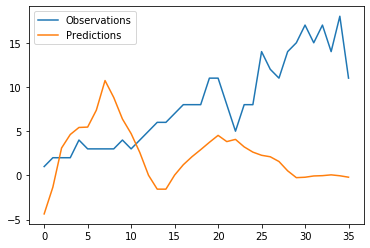

In [58]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [112]:
y_test

array([ 1,  2,  2,  2,  4,  3,  3,  3,  3,  4,  3,  4,  5,  6,  6,  7,  8,
        8,  8, 11, 11,  8,  5,  8,  8, 14, 12, 11, 14, 15, 17, 15, 17, 14,
       18, 11])

In [ ]:
if np.any(np.isnan(y_hat)):
    errors.append(np.nan)
else:
    errors.append(math.sqrt(mean_squared_error(y_test,y_hat)))

In [29]:
%load_ext tensorboard

In [30]:
!rm -rf ./logs/ 

In [371]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

In [373]:
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = n_steps *2 ),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(1),
    ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='mean_squared_error',
      metrics=['RootMeanSquaredError'],
    )

    model.fit(x_train, y_train, epochs=100,verbose=False) # Run with 1 epoch to speed things up for demo purposes
    _, rmse = model.evaluate(x_test, y_test)
    return rmse


In [374]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)

In [375]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1



--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 19.1536 - RootMeanSquaredError: 4.3765
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
48/48 [==============================] - 0s 1ms/sample - loss: 47.7244 - RootMeanSquaredError: 6.9083
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 18.5791 - RootMeanSquaredError: 4.3103
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
48/48 [==============================] - 0s 1ms/sample - loss: 47.5877 - RootMeanSquaredError: 6.8984
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
48/48 [==============================] - 0s 1ms/sample - loss: 21.7139 - RootMeanSquaredError: 4.6598
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
48/48 [

In [23]:
!kill 27181

In [253]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 28404), started 7:23:30 ago. (Use '!kill 28404' to kill it.)

In [59]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([4,8,16])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([4,8]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
METRIC_RMSE = 'RootMeanSquaredError'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_DROPOUT,HP_L2 ,HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')],
  )

In [60]:
def train_test_model(hparams):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = x_train.shape[1]),
        layers.Dense(hparams[HP_NUM_UNITS1], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dropout(hparams[HP_DROPOUT]),
        layers.Dense(hparams[HP_NUM_UNITS2], kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
        layers.Dense(1)
    ])

    model.compile(optimizer=hparams[HP_OPTIMIZER],
                loss='mean_squared_error',
                metrics=['RootMeanSquaredError'])

    model.fit(x_train, y_train, epochs=100,verbose=False) 
    _, rmse = model.evaluate(x_test, y_test)
    return rmse

In [61]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        rmse = train_test_model(hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
    return(rmse, hparams)

In [62]:
session_num = 0
min_rmse = float('inf')
best_hparams = {}
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
            for l2 in (HP_L2.domain.min_value, HP_L2.domain.max_value):
                for optimizer in HP_OPTIMIZER.domain.values:
                    hparams = {
                        HP_NUM_UNITS1: num_units1,
                        HP_NUM_UNITS2: num_units2,
                        HP_DROPOUT: dropout_rate,
                        HP_L2: l2,
                        HP_OPTIMIZER: optimizer
                    }
                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    rmse, current_hparams = run('logs/hparam_tuning/' + run_name, hparams)
                    if (~np.isnan(rmse)) and (rmse < min_rmse): 
                        best_hparams = current_hparams
                        min_rmse = rmse
                        print("mis_rmse {}".format(min_rmse))
                    session_num += 1

--- Starting trial: run-0
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 449us/sample - loss: 17.8580 - RootMeanSquaredError: 4.2251
mis_rmse 4.225065231323242
--- Starting trial: run-1
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 412us/sample - loss: 10.4366 - RootMeanSquaredError: 3.2289
mis_rmse 3.228870153427124
--- Starting trial: run-2
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 407us/sample - loss: 41.9251 - RootMeanSquaredError: 6.0395
--- Starting trial: run-3
{'num_units 1': 4, 'num_units 2': 4, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 419us/sample - loss: 15.8140 - RootMeanSquaredError: 3.9760
--- Starting trial

156/156 [==============================] - 0s 487us/sample - loss: 40.0987 - RootMeanSquaredError: 6.0327
--- Starting trial: run-36
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 413us/sample - loss: 10.9880 - RootMeanSquaredError: 3.3129
--- Starting trial: run-37
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'adam'}
156/156 [==============================] - 0s 472us/sample - loss: 11.7133 - RootMeanSquaredError: 3.4203
--- Starting trial: run-38
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.001, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 569us/sample - loss: 46.9215 - RootMeanSquaredError: 6.0434
--- Starting trial: run-39
{'num_units 1': 8, 'num_units 2': 8, 'dropout': 0.1, 'l2 regularizer': 0.01, 'optimizer': 'RMSprop'}
156/156 [==============================] - 0s 514us/sample - loss: 1

156/156 [==============================] - 0s 449us/sample - loss: 12.0740 - RootMeanSquaredError: 3.4720
--- Starting trial: run-71
{'num_units 1': 16, 'num_units 2': 8, 'dropout': 0.3, 'l2 regularizer': 0.01, 'optimizer': 'sgd'}
156/156 [==============================] - 0s 404us/sample - loss: 1240754091246746171604992.0000 - RootMeanSquaredError: 29829.9004


In [64]:
list(best_hparams.values())

[16, 4, 0.3, 0.01, 'RMSprop']

In [69]:
min_rmse

3.0939493

In [58]:
!rm -rf ./logs/ 

In [57]:
!kill 3869

In [66]:
%reload_ext tensorboard

In [67]:
%tensorboard --logdir logs/hparam_tuning

In [443]:
for key in best_hparams.keys():
    print(key)

<HParam 'num_units 1': {4, 8, 16}>
<HParam 'num_units 2': {4, 8}>
<HParam 'dropout': [0.1, 0.3]>
<HParam 'l2 regularizer': [0.001, 0.01]>
<HParam 'optimizer': {'RMSprop', 'adam', 'sgd'}>


In [27]:
list(best_hparams.values())

[32, 8, 0.1, 0.001, 'adam']

In [68]:
min_rmse

3.0939493

In [321]:
!rm -rf ./logs/ 

In [349]:
%load_ext tensorboard

In [350]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6006 (pid 13393), started 6:38:46 ago. (Use '!kill 13393' to kill it.)

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = n_steps),
    layers.Dense(16, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dropout(0.3),
    layers.Dense(4, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=tf.nn.relu),
    layers.Dense(1)
])

In [92]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
            loss='mean_squared_error',
            metrics=['RootMeanSquaredError'])

In [93]:
model.fit(x_train, y_train, epochs=50, verbose=False) 

ValueError: Error when checking input: expected input_363 to have shape (20,) but got array with shape (1,)

In [78]:
 _, rmse = model.evaluate(x_test, y_test)

36/36 [==============================] - 0s 2ms/sample - loss: 3.1590 - RootMeanSquaredError: 1.7710


In [79]:
y_hat = forecast(np.append(x_train[-1][1:],np.array(y_train[-1])), model, h, n_steps)
y_hat = np.reshape(y_hat,len(y_test))

In [80]:
math.sqrt(mean_squared_error(y_test,y_hat))

4.765650975995383

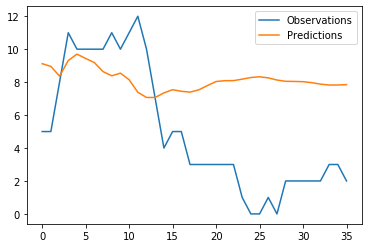

In [81]:
plt.plot(range(len(y_test)), y_test, label="Observations")
plt.plot(range(len(y_test)), y_hat, label="Predictions")
plt.legend()

In [36]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

In [44]:
#data[22,8,2:dim(data)[3]]  #cluster==2
#x<-data[28,7,3:dim(data)[3]]   #cluster==0
x = data[21,7,]

NameError: name 'epochs' is not defined

In [62]:
X_train

array([[0.02, 0.02, 0.01, ..., 0.  , 0.  , 1.73],
       [0.02, 0.01, 0.  , ..., 0.  , 1.73, 0.09],
       [0.01, 0.  , 0.08, ..., 1.73, 0.09, 0.18],
       ...,
       [0.02, 0.01, 0.  , ..., 0.  , 0.19, 0.09],
       [0.01, 0.  , 0.31, ..., 0.19, 0.09, 0.1 ],
       [0.  , 0.31, 0.  , ..., 0.09, 0.1 , 0.  ]], dtype=float32)

In [38]:
n=30
# Set forecasting window length (in years)
m=3
# Set start year
start = 1948
origin = 1980
# Set annual sampling rate
f = 12
h = m*f

index = (origin - start) * f +1

#x.ts <- x[index:length(x)-1]

train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

In [42]:
train_start

385

In [39]:
univariate_past_history = n*f
univariate_future_target = 1

x_train_uni, y_train_uni = univariate_data(x, train_start, test_start,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(x, test_start, test_end,
                                       univariate_past_history,
                                       univariate_future_target)

In [26]:
def create_time_steps(length):
    return list(range(-length, 0))

In [27]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                label=labels[i])
        else:
             plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


In [28]:
def baseline(history):
    return np.mean(history)

In [29]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


IndexError: index 0 is out of bounds for axis 0 with size 0

In [40]:
x_train_uni

array([], dtype=float64)